In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

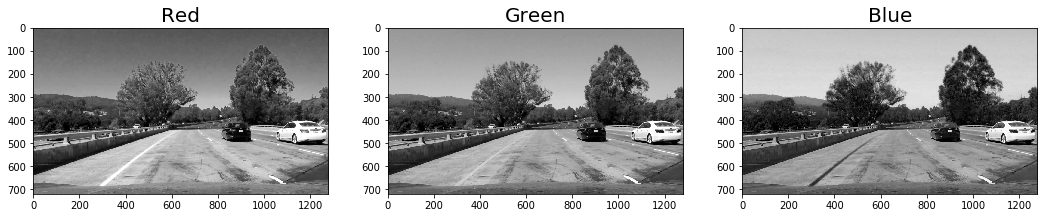

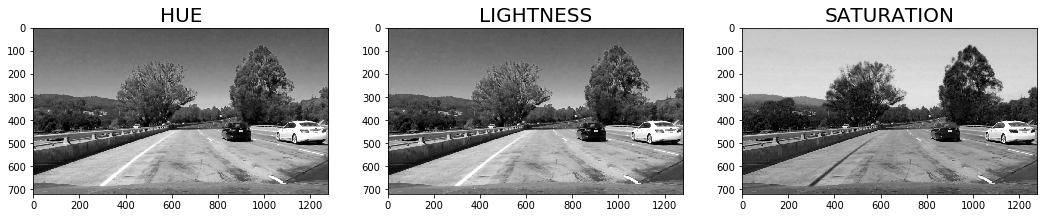

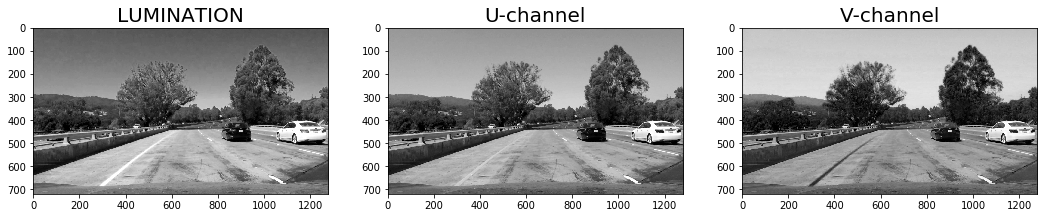

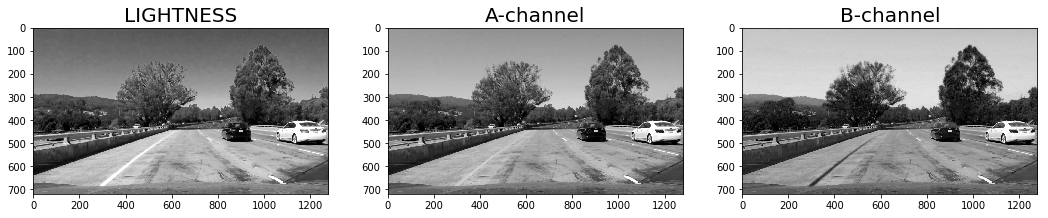

In [3]:
image = mpimg.imread('test_images/test1.jpg')

R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]

hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

H = image[:,:,0]
L = image[:,:,1]
S = image[:,:,2]

luv = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)

L = image[:,:,0]
U = image[:,:,1]
V = image[:,:,2]

lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

L = image[:,:,0]
A = image[:,:,1]
B = image[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.imshow(R, cmap='gray')
ax1.set_title('Red', fontsize=20)
ax2.imshow(G, cmap='gray')
ax2.set_title('Green', fontsize=20)
ax3.imshow(B, cmap='gray')
ax3.set_title('Blue', fontsize=20)
plt.savefig('output_images/red_green_blue', bbox_inches='tight')
plt.show()

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.imshow(H, cmap='gray')
ax1.set_title('HUE', fontsize=20)
ax2.imshow(L, cmap='gray')
ax2.set_title('LIGHTNESS', fontsize=20)
ax3.imshow(S, cmap='gray')
ax3.set_title('SATURATION', fontsize=20)
plt.savefig('output_images/HLS.jpg', bbox_inches='tight')
plt.show()

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.imshow(L, cmap='gray')
ax1.set_title('LUMINATION', fontsize=20)
ax2.imshow(U, cmap='gray')
ax2.set_title('U-channel', fontsize=20)
ax3.imshow(V, cmap='gray')
ax3.set_title('V-channel', fontsize=20)
plt.savefig('output_images/LUV.jpg', bbox_inches='tight')
plt.show()

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.imshow(L, cmap='gray')
ax1.set_title('LIGHTNESS', fontsize=20)
ax2.imshow(A, cmap='gray')
ax2.set_title('A-channel', fontsize=20)
ax3.imshow(B, cmap='gray')
ax3.set_title('B-channel', fontsize=20)
plt.savefig('output_images/LAB.jpg', bbox_inches='tight')
plt.show()

In [4]:
def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100):
    """
    Takes an image, gradient orientation, and threshold min/max values
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=31))
    if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=31))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [5]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
    """
    Return the magnitude of the gradient
    for a given sobel kernel size and threshold values
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [6]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Return the direction of the gradient
    for a given sobel kernel size and threshold values
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [7]:
def hls_thresh(img, thresh=(100, 255)):
    """
    Convert RGB to HLS and threshold to binary image using S channel
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [8]:
def combined_thresh(img):
    abs_bin = abs_sobel_thresh(img, orient='x', thresh_min=50, thresh_max=255)
    mag_bin = mag_thresh(img, sobel_kernel=21, mag_thresh=(80, 100))
    dir_bin = dir_threshold(img, sobel_kernel=11, thresh=(0.1, 0.2))
    hls_bin = hls_thresh(img, thresh=(170, 255))

    combined = np.zeros_like(dir_bin)
    combined[(abs_bin == 1) | (mag_bin == 1) | (dir_bin == 1)] = 1
              # & (dir_bin == 1))) | hls_bin == 1

    return combined, abs_bin, mag_bin, dir_bin, hls_bin  # DEBUG

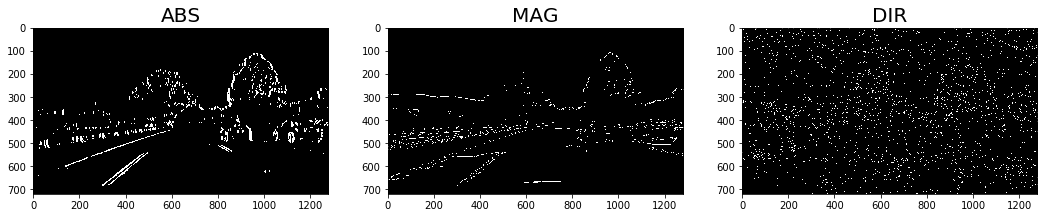

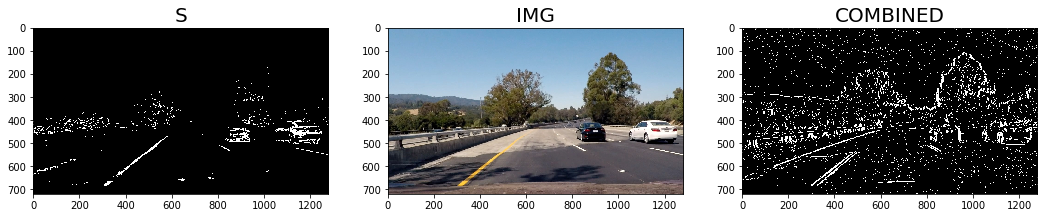

In [9]:
__name__ == '__main__'

if __name__ == '__main__':
    image = 'test_images/test4.jpg'
    #image = 'test_images/test19.jpg'

    img = mpimg.imread(image)

    combined, abs_bin, mag_bin, dir_bin, hls_bin = combined_thresh(img)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    ax1.imshow(abs_bin, cmap='gray')
    ax1.set_title('ABS', fontsize=20)
    ax2.imshow(mag_bin, cmap='gray')
    ax2.set_title('MAG', fontsize=20)
    ax3.imshow(dir_bin, cmap='gray')
    ax3.set_title('DIR', fontsize=20)
    plt.savefig('output_images/red_green_blue', bbox_inches='tight')
    plt.show()
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    ax1.imshow(hls_bin, cmap='gray')
    ax1.set_title('S', fontsize=20)
    ax2.imshow(img)
    ax2.set_title('IMG', fontsize=20)
    ax3.imshow(combined, cmap='gray')
    ax3.set_title('COMBINED', fontsize=20)
    plt.savefig('output_images/red_green_blue', bbox_inches='tight')
    plt.show()

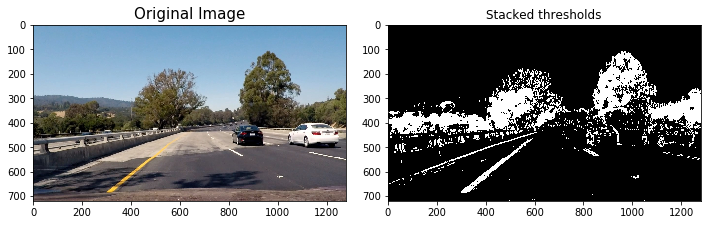

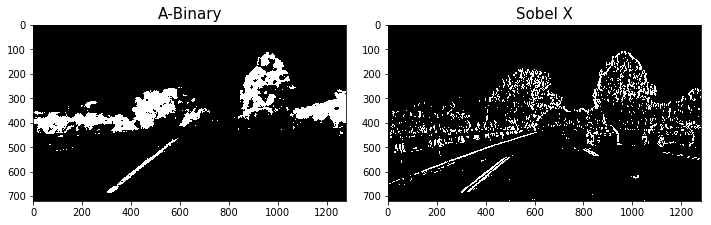

In [43]:
def binary_warp(img, read = True, show = True):
    if read:
        #img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Convert to HLS color space and separate the S channel

        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        a_channel = lab[:,:,1]
        
        # Sobel x
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=21) # Take the derivative in x
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=31)
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate l
        abs_sobely = np.absolute(sobely)#ines away from horizontal
        scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
        scaled_sobel_y = np.uint8(255 * abs_sobely / np.max(abs_sobely))
        
        
        # Threshold x gradient
        thresh_min = 30
        thresh_max = 150
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1


        a_thresh_min = 50 #95 
        a_thresh_max = 122  #115
        a_binary = np.zeros_like(a_channel)
        a_binary[(a_channel >= a_thresh_min) & (a_channel <= a_thresh_max)] = 1

        
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(a_binary == 1) | (sxbinary == 1)] = 1
        
    if show:
        # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        f.tight_layout()

        
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=15)
        ax2.imshow(combined_binary, cmap="gray")
        ax2.set_title("Stacked thresholds")
        
        #ax3.imshow(combined_binary, cmap='gray')
        #ax3.set_title('Combined Binary', fontsize=15)
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        f.tight_layout()

        
        ax1.imshow(a_binary, cmap='gray')
        ax1.set_title('A-Binary', fontsize=15)
        ax2.imshow(sxbinary, cmap='gray')
        ax2.set_title('Sobel X', fontsize=15)

        plt.savefig('output_images/combined_image.jpg', bbox_inches='tight')
    else: 
        return color_combined
    
for image in glob.glob('test_images/test4.jpg'):
    img = mpimg.imread(image)
    binary_warp(img)   

In [ ]:
def binary_warp(img, read = True, show = True):
    if read:
        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        l_channel = luv[:,:,2]
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        a_channel = lab[:,:,2]
        

        # Sobel x
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        max_value = np.max(abs_sobelx)
        scaled_sobel = np.uint8(255 * abs_sobelx / max_value)


        # S hls
        s_thresh_min = 180 #170
        s_thresh_max = 255 #255
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

        # V luv
        l_thresh_min = 10 #220
        l_thresh_max = 100 #255
        l_binary = np.zeros_like(l_channel)
        l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

        # B lab 
        a_thresh_min = 100 #95 
        a_thresh_max = 200  #115
        a_binary = np.zeros_like(a_channel)
        a_binary[(a_channel >= a_thresh_min) & (a_channel <= a_thresh_max)] = 1

        # Threshold x gradient
        thresh_min = 30
        thresh_max = 100
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        
        color_threshold = 100
        R = img[:,:,0]
        G = img[:,:,1]
        color_combined = np.zeros_like(R)
        r_g_condition = (R > color_threshold) & (G > color_threshold)
        
        #color_combined[(r_g_condition & l_binary) & (s_binary | sxbinary)] = 1


        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(s_binary == 1) | (sxbinary == 1) |
                        (l_binary == 1) | (a_binary == 1)] = 1
    

    

    if show:
        # Plot the result
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
        f.tight_layout()

        ax1.imshow(s_binary, cmap='gray')
        ax1.set_title('S hls', fontsize=15)
        ax2.imshow(l_binary, cmap='gray')
        ax2.set_title('V luv', fontsize=15)
        ax3.imshow(a_binary, cmap='gray')
        ax3.set_title('B lab', fontsize=15)
        plt.savefig('output_images/thresh_image.jpg', bbox_inches='tight')
        
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
        f.tight_layout()
        
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=15)
        ax2.imshow(r_g_condition, cmap='gray')
        ax2.set_title('R-G', fontsize=15)
        ax3.imshow(combined_binary, cmap='gray')
        ax3.set_title('Combined Binary', fontsize=15)
        plt.savefig('output_images/combined_image.jpg', bbox_inches='tight')
    else: 
        return color_combined
    
for img in glob.glob('test_images/test4.jpg'):
    binary_warp(img)   

In [ ]:
def c_img(image, show=True, read = True): # Contrast Limited Adaptive Histogram Equalization
    
    if read:
        img = mpimg.imread(image)
        #----Convert to  lab colorspace
        lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        #----Splitting the LAB image to different channels
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=4, tileGridSize=(4,4))
        cl = clahe.apply(l)
         #----Merge the CLAHE enhanced L-channel with the a and b channel
        limg = cv2.merge((cl,a,b))
        #----Converting image from LAB Color model to RGB model
        clahe = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(clahe)
        ax2.set_title('CLAHE Image', fontsize=20)
        plt.savefig('output_images/CLAHE.jpg', bbox_inches='tight')
        
    else:
        return clahe
    
for image in glob.glob('test_images/test7.jpg'):
    c_img(image)